In [1]:
import pandas as pd
import numpy as np
import joblib
import pickle
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from chunkdot import cosine_similarity_top_k

In [4]:
df = pd.read_csv('../data/movie.csv')
df.head(2)

,id,title,year_release,duration,genre,rating,metascore,director,cast,votes,description,img_url
0,tt0439572,The Flash,2023,144 min,"Action, Adventure, Fantasy",7.2,56.0,Andy Muschietti,"Ezra Miller,Michael Keaton,Sasha Calle,Michael...","66,700",Barry Allen uses his super speed to change the...,https://m.media-amazon.com/images/M/MV5BZWE2ZW...
1,tt9362722,Spider-Man: Across the Spider-Verse,2023,140 min,"Animation, Action, Adventure",8.9,86.0,Joaquim Dos Santos,"Kemp Powers,Justin K. Thompson,Shameik Moore,H...","151,801","Miles Morales catapults across the Multiverse,...",https://m.media-amazon.com/images/M/MV5BMzI0Nm...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            50000 non-null  object 
 1   title         50000 non-null  object 
 2   year_release  49850 non-null  object 
 3   duration      46430 non-null  object 
 4   genre         49995 non-null  object 
 5   rating        42406 non-null  float64
 6   metascore     39691 non-null  float64
 7   director      49995 non-null  object 
 8   cast          49958 non-null  object 
 9   votes         42406 non-null  object 
 10  description   50000 non-null  object 
 11  img_url       50000 non-null  object 
dtypes: float64(2), object(10)
memory usage: 4.6+ MB


In [6]:
df.isnull().sum()

id                  0
title               0
year_release      150
duration         3570
genre               5
rating           7594
metascore       10309
director            5
cast               42
votes            7594
description         0
img_url             0
dtype: int64

Convert votes and year_release to float

In [7]:
df['votes'] = df['votes'].str.replace(',', '').astype(float)
df['year_release'] = df['year_release'].str.extract('(\d+)').astype(float)

# **Consine Similarities Preparation**
First, Tag column preparation as a combination between genre, director, cast, and description. Tag will later be used to calculate the similarities in order to develop content-based filtering recommender system.

In [5]:
columns_tag = ['genre', 'director', 'cast', 'description']
df['tag'] = df[columns_tag].astype('str').apply(lambda column : ' '.join(column), axis=1)

(0.0, 2500.0)

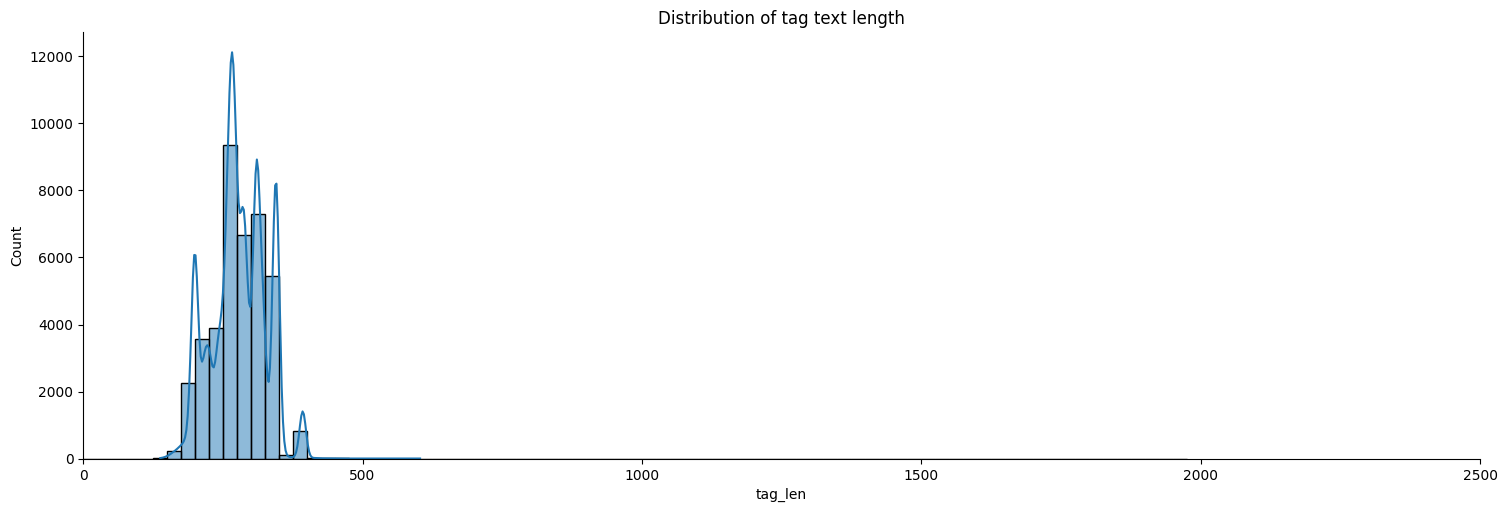

In [6]:
df['tag_len'] = df['tag'].apply(lambda x: len(x))

# illustrate the tag text length
sns.displot(data=df.dropna(), bins=list(range(0, 2000, 25)), height=5, x='tag_len', aspect=3, kde=True)
plt.title('Distribution of tag text length')
plt.xlim([0, 2500])

Second, data are being quantify the importance of word and vectorize the result for further processing.  

In [7]:
tfidf = TfidfVectorizer(max_features=5000, analyzer='word', stop_words='english')
tfidf_vector= tfidf.fit_transform(df['tag'])

print("Shape:", tfidf_vector.shape)
print(list(enumerate(tfidf.get_feature_names_out()))[:5])

Shape: (50000, 5000)
[(0, '000'), (1, '10'), (2, '11'), (3, '12'), (4, '13')]


In [2]:
path = "../data/npz/similarity_matrix.npz"

try:
    sim_mat = sparse.load_npz(path)
    
except (FileNotFoundError, IOError):
    sim_mat = cosine_similarity_top_k(tfidf_vector, top_k=20)
    sparse.save_npz(path, sim_mat)

print("shape: ", sim_mat.shape)

shape:  (50000, 50000)


fifth, re-ranking of similarity scores are being performed in order to enhance performance. Re-ranking implement year release, metascore, and rating. 

In [8]:
year_normalize = MinMaxScaler().fit_transform(df['year_release'].values.reshape(-1, 1))
metascore_normalize = MinMaxScaler().fit_transform(df['metascore'].values.reshape(-1, 1))
rating_normalize = MinMaxScaler().fit_transform(df['rating'].values.reshape(-1, 1))
votes_normalize = MinMaxScaler().fit_transform(df['votes'].values.reshape(-1, 1))

In [16]:
re_ranked_sim_mat = sparse.csr_matrix(
                        sim_mat.multiply(year_normalize)
                                .multiply(metascore_normalize)
                                .multiply(rating_normalize)
                                .multiply(votes_normalize))

print("shape: ", re_ranked_sim_mat.shape)
re_ranked_sim_mat

MemoryError: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64

In [13]:
sparse.save_npz("../data/npz/re_ranked_sim_mat.npz", re_ranked_sim_mat)